## Exploring Malaria Simulation Output Data

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

strategies = ['status_quo',
              'AL5',
              'AL4',
              'ASAQ',
              'ASAQ25-DHA-PPQ75',
              'AL75-ASAQ25',
              'AL25-DHA-PPQ75',
              'AL25-ASAQ75',
              'ASAQ50-DHA-PPQ50',
              'AL50-DHA-PPQ50',
              'DHA-PPQ',
              'AL75-DHA-PPQ25']

table_names = ['monthlydata', 'sqlite_sequence', 'monthlysitedata', 'genotype', 'monthlygenomedata']
 
def get_all_tables(db: str) -> list:
    """
    Get all tables in a sqlite3 database

    Args:
    db (str): path to sqlite3 database

    Returns:
    list: list of tables in the database
    """
    # Validate input file path
    if not os.path.exists(db):
        raise FileNotFoundError(f"File not found: {db}")
    with sqlite3.connect(db) as conn:
        c = conn.cursor()
        c.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = c.fetchall()
    
    return [table[0] for table in tables]

def get_table(db: str, table: str) -> pd.DataFrame:
    """
    Get a table from a sqlite3 database

    Args:
    db (str): path to sqlite3 database
    table (str): name of table to get

    Returns:
    pd.DataFrame: table as a pandas DataFrame
    """
    # Validate input file path
    if not os.path.exists(db):
        raise FileNotFoundError(f"File not found: {db}")
    with sqlite3.connect(db) as conn:
        df = pd.read_sql_query(f"SELECT * FROM {table}", conn)
    
    return df

def calculate_treatment_failure_rate(data: pd.DataFrame, locationid: int = 0) -> pd.DataFrame:
    """
    Calculate treatment failures for a given table

    Args:
    data (DataFrame): monthlysitedata table to calculate treatment failures
    locationid (int): locationid to filter by

    Returns:
    pd.DataFrame: table with treatment failures
    """
    # Calculate treatment failures
    if locationid > 0:
        data = data[data["locationid"] == locationid]
    data['failure_rate'] = data['treatmentfailures'] / data['treatments']

    return data

def aggregate_monthlysitedata(path: str, strategy: str, locationid: int = 0) -> pd.DataFrame:
    """
    Aggregate data by strategy. This function searchs path for all the result files for the given strategy and aggregates them.

    Args:
    path (str): path to search for result files
    strategy (str): strategy to aggregate data for

    Returns:
    pd.DataFrame: aggregated data
    pd.Series: monthlydataid column
    """
    # Get all files for the strategy
    files = glob.glob(os.path.join(f"{path}", f"*_{strategy}_*.db"))
    if len(files) == 0:
        print(f"No files found for strategy {strategy}")
        return
    # Get the monthlysitedata table for the first file to set up aggregated data
    monthlysitedata_columns = get_table(files[0], 'monthlysitedata').columns.to_list()
    monthlysitedata_columns.remove('monthlydataid')
    monthlysitedata_columns.append('failure_rate')
    monthlysitedata = {column : pd.DataFrame() for column in monthlysitedata_columns}    
    # Aggregate data for the rest of the files
    for file in files:
        # print(f"Aggregating data for {file}")
        data = get_table(file, 'monthlysitedata')
        if locationid > 0:
            data = data[data["locationid"] == locationid]
        if 'failure_rate' not in data.columns:
            data = calculate_treatment_failure_rate(data)
        monthlydataid = data['monthlydataid']
        for column in monthlysitedata_columns:            
            if column != 'monthlydataid':                
                monthlysitedata[column] = pd.concat([monthlysitedata[column], data[column]], axis=1)
    # Calculate statistics for the aggregated data
    for column in monthlysitedata_columns:
        if column != 'monthlydataid':
            monthlysitedata[column]['mean'] = monthlysitedata[column].mean(axis=1)
            monthlysitedata[column]['median'] = monthlysitedata[column].median(axis=1)
            monthlysitedata[column]['95th'] = monthlysitedata[column].quantile(axis=1, q=0.95)
            monthlysitedata[column]['5th'] = monthlysitedata[column].quantile(axis=1, q=0.05)           
            
    return monthlysitedata, monthlydataid

def save_aggregated_data(monthlysitedata: dict[str, pd.DataFrame], monthlydataid: pd.Series, strategy: str, path: str):
    """
    Save aggregated data to a file

    Args:
    monthlysitedata (dict[str, pd.DataFrame]): aggregated data
    monthlydataid (pd.Series): monthlydataid column
    strategy (str): strategy
    path (str): path to save the file
    """
    with sqlite3.connect(os.path.join(path, f"{strategy}_aggregated.db")) as conn:
        for column in monthlysitedata.keys():
            monthlysitedata[column].to_sql(column, conn, index=False)
        monthlydataid.to_sql('monthlydataid', conn, index=False)

In [281]:
data, months = aggregate_monthlysitedata("output", "status_quo", 1)

In [ ]:
def plot_strategy_treatment_failure(data: pd.DataFrame, months: pd.DataFrame, strategy: str, figsize: tuple = (18, 3)):
    """
    Plot treatment failure rate for a given strategy

    Args:
        data (pd.DataFrame): treatement failure data to plot
        months (pd.DataFrame): months for the data
        strategy (str): strategy to plot
        figsize (tuple): figure size
    
    Returns:    
        tuple: figure and axis
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(months / 12, data['failure_rate']['mean'], label='Mean')
    ax.fill_between(months / 12, data['failure_rate']['5th'], data['failure_rate']['95th'], color='b', alpha=0.15, label='5th-95th percentile')
    ax.axhline(y=0.1, color='r', linestyle='--', label='10% threshold')
    ax.set_title(f"{strategy} Treatment Failure Rate")
    ax.set_xlabel("Years")
    ax.set_ylabel("Treatment Failure Rate")
    ax.legend()
    return fig, ax

In [283]:
data['treatmentfailures']

,treatmentfailures,treatmentfailures,treatmentfailures,treatmentfailures,treatmentfailures,treatmentfailures,treatmentfailures,treatmentfailures,treatmentfailures,treatmentfailures,treatmentfailures,mean,median,95th,5th
0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.0,0.00
30,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.0,0.00
60,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.0,0.00
90,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.0,0.00
120,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11400,551,674,484,801,666,546,545,503,574,533,514,581.000000,548.500000,724.8,496.35
11430,384,483,332,492,427,344,362,393,388,386,357,395.272727,387.000000,486.6,339.80
11460,302,378,277,439,388,276,310,326,380,322,283,334.636364,324.000000,408.4,276.65
11490,308,417,272,406,370,317,293,279,376,335,301,334.000000,325.500000,410.4,276.55


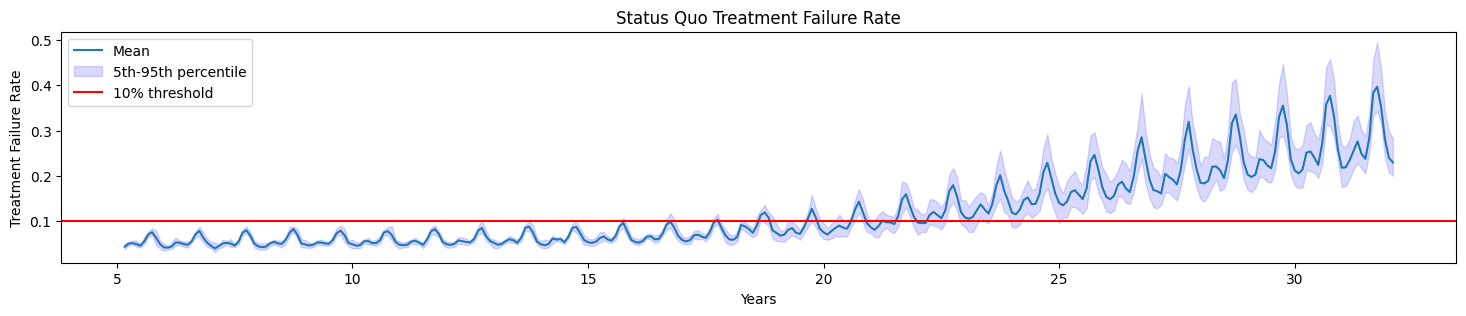

In [285]:
fig, ax = plot_strategy_treatment_failure(data, months, "Status Quo")
plt.show()

In [ ]:
def plot_strategy_results(path: str, strategy: str, locationid:int = 0) -> plt.Figure:
    """
    Plots the treatment failure rate for a given strategy. If locationid is provided, only that location is plotted.
    If more than one results file is found in the path, the data is aggregated.

    Args:
    path (str): path to directory containing results files
    strategy (str): strategy to plot
    locationid (int): locationid to filter by

    Returns:
    plt.Figure: matplotlib figure
    """
    # Assert that the location is valid
    if locationid < 0:
        raise ValueError("locationid must be a positive integer")
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    # Get all results files in the path
    results_files = glob.glob(os.path.join(path, f"*_{strategy}_.db"))
    if len(results_files) == 0:
        raise FileNotFoundError(f"No results files found for strategy {strategy}")
    # Read all results files
    failures = pd.DataFrame()
    for file in results_files:
        data = get_table(file, 'monthlysitedata')
        data = calculate_treatment_failure_rate(data, locationid)
        failures[file] = data['failure_rate']
        
    if locationid > 0:
        failures = failures.loc[failures['locationid'] == locationid]
    # else, aggregate all locations by taking the mean of the failure rates at each month
    else:
        months = failures['monthlydataid'].unique()
        monthly_average = pd.DataFrame()
        for month in months:
            monthly_data = failures.loc[failures['monthlydataid'] == month]
            monthly_average[month, 'population'] = monthly_data['population'].sum()
            monthly_average[month, 'treatments'] = monthly_data['treatments'].sum()
            monthly_average[month, 'treatmentfailures'] = monthly_data['treatmentfailures'].sum()
            monthly_average[month, 'failure_rate'] = monthly_data['failure_rate'].mean()


    failures['mean'] = failures.mean(axis=1)


    fig, ax = plt.subplots()
    ax.plot(failures['monthlydataid'])

['output/rwanda_AL5_4_monthly_data_0.db', 'output/rwanda_AL5_7_monthly_data_0.db', 'output/rwanda_AL5_0_monthly_data_0.db', 'output/rwanda_AL5_8_monthly_data_0.db', 'output/rwanda_AL5_3_monthly_data_0.db', 'output/rwanda_AL5_1_monthly_data_0.db', 'output/rwanda_AL50-DHA-PPQ50_0_monthly_data_0.db', 'output/rwanda_AL5_6_monthly_data_0.db', 'output/rwanda_AL5_5_monthly_data_0.db', 'output/rwanda_AL5_2_monthly_data_0.db', 'output/rwanda_AL5_9_monthly_data_0.db', 'output/rwanda_AL50-DHA-PPQ50_1_monthly_data_0.db', 'output/rwanda_AL5_10_monthly_data_0.db']


In [77]:
ser = pd.Series()
# set the index of ser to be the range of values from 0 to 10

In [69]:
ser['a'] =1

In [71]:
ser['b'] = 2

In [72]:
ser

a    1
b    2
dtype: int64

In [65]:
data = get_table('./output/rwanda_AL5_0_monthly_data_0.db', 'monthlysitedata')

In [76]:
data.columns

Index(['monthlydataid', 'locationid', 'population', 'clinicalepisodes',
       'clinicalepisodes_by_age_class_0_1',
       'clinicalepisodes_by_age_class_1_2',
       'clinicalepisodes_by_age_class_2_3',
       'clinicalepisodes_by_age_class_3_4',
       'clinicalepisodes_by_age_class_4_5',
       'clinicalepisodes_by_age_class_5_6',
       'clinicalepisodes_by_age_class_6_7',
       'clinicalepisodes_by_age_class_7_8',
       'clinicalepisodes_by_age_class_8_9',
       'clinicalepisodes_by_age_class_9_10',
       'clinicalepisodes_by_age_class_10_11',
       'clinicalepisodes_by_age_class_11_15',
       'clinicalepisodes_by_age_class_15_20',
       'clinicalepisodes_by_age_class_20_60',
       'clinicalepisodes_by_age_class_60_100', 'treatments',
       'treatmentfailures', 'eir', 'pfprunder5', 'pfpr2to10', 'pfprall',
       'infectedindividuals', 'nontreatment', 'under5treatment',
       'over5treatment'],
      dtype='object')

In [3]:
def get_df_from_db(table, location_id, db_path):
    
    # connect to database
    conn = sqlite3.connect(db_path)

    # create a cursor object
    cursor = conn.cursor()
    
    # Execute sql query
    query_str = "SELECT * FROM "+  table + " where locationid = " + str(location_id)
    cursor.execute(query_str)

    # Fetch all the results
    results = cursor.fetchall()
    
    # Retrieve the column names
    headers = [description[0] for description in cursor.description]
    
    # Convert to pandas DataFrame
    df = pd.DataFrame(results, columns=headers)
    print("loaded data frame corresponding to table", table," location id ", location_id, " with shape ", df.shape)
    
    # Close the connection
    conn.close()
    
    return df
    

In [4]:
directory = "../Temple-Malaria-Simulation/build/bin/"
    

# Compare treatment failure rates across different strategies
location_id =2
strategy_filename_map = {"rwa-pfpr-constant" : "monthly_data_0.db", "rwa-replacement-asaq" : "monthly_data_1.db", "rwa-mft-al-asaq" : "monthly_data_2.db", "rwa-replacement-dhappq" : "monthly_data_3.db", "rwa-mft-al-asaq-0.25" : "monthly_data_4.db" , "rwa-mft-al-asaq-0.75" : "monthly_data_5.db"}
df_list = []

for strategy, filename in strategy_filename_map.items(): 
    monthly_site_data_df = get_df_from_db("monthlysitedata", location_id, directory+filename)
    monthly_site_data_df['treatment_failure_rate'] = monthly_site_data_df['treatmentfailures'] / monthly_site_data_df['infectedindividuals'] 
    monthly_site_data_df['strategy'] = strategy 
    strategy_month_failure_df = monthly_site_data_df[['strategy', 'monthlydataid', 'treatment_failure_rate', 'pfprunder5', 'pfprall', 'clinicalepisodes']]
    df_list.append(strategy_month_failure_df)
# Concatenate all DataFrames into one DataFrame
strategy_tf_df = pd.concat(df_list, ignore_index=True)

OperationalError: no such table: monthlysitedata

In [5]:
strategy_tf_df

NameError: name 'strategy_tf_df' is not defined

In [35]:
def visualize_strategy_comparison_metric(df, location_id, metric):
    
    plt.figure(figsize=(14, 10))

    # Loop through the unique strategies and plot a line for each
    for strategy in df['strategy'].unique():
        strategy_data = df[df['strategy'] == strategy]
        plt.plot(strategy_data['monthlydataid'], strategy_data[metric], label=strategy)

    # Adding titles and labels
    plt.title(metric + 'Across Months for Different Strategies for location'+str(location_id))
    plt.xlabel('Month')
    plt.ylabel(metric)
    plt.legend(title='Strategy')

    plt.tight_layout()
    plt.show()
    # plt.savefig(metric + '_comparison_for_strategies_'+str(location_id) + '.png')  # Save the plot as a file
    plt.close()

In [35]:
def visualize_treatment_failures(df, location_id):
    
    plt.figure(figsize=(14, 10))

    # Loop through the unique strategies and plot a line for each
    for strategy in df['strategy'].unique():
        strategy_data = df[df['strategy'] == strategy]
        plt.plot(strategy_data['monthlydataid'], strategy_data['treatment_failure_rate'], label=strategy)

    # Adding titles and labels
    plt.title('Treatment Failures Across Months for Different Strategies for location'+str(location_id))
    plt.xlabel('Month')
    plt.ylabel('Treatment Failure Rate')
    plt.legend(title='Strategy')

    plt.tight_layout()
    plt.show()
    # plt.savefig('treatment_failure_for_strategies_'+str(location_id) + '.png')  # Save the plot as a file
    plt.close()

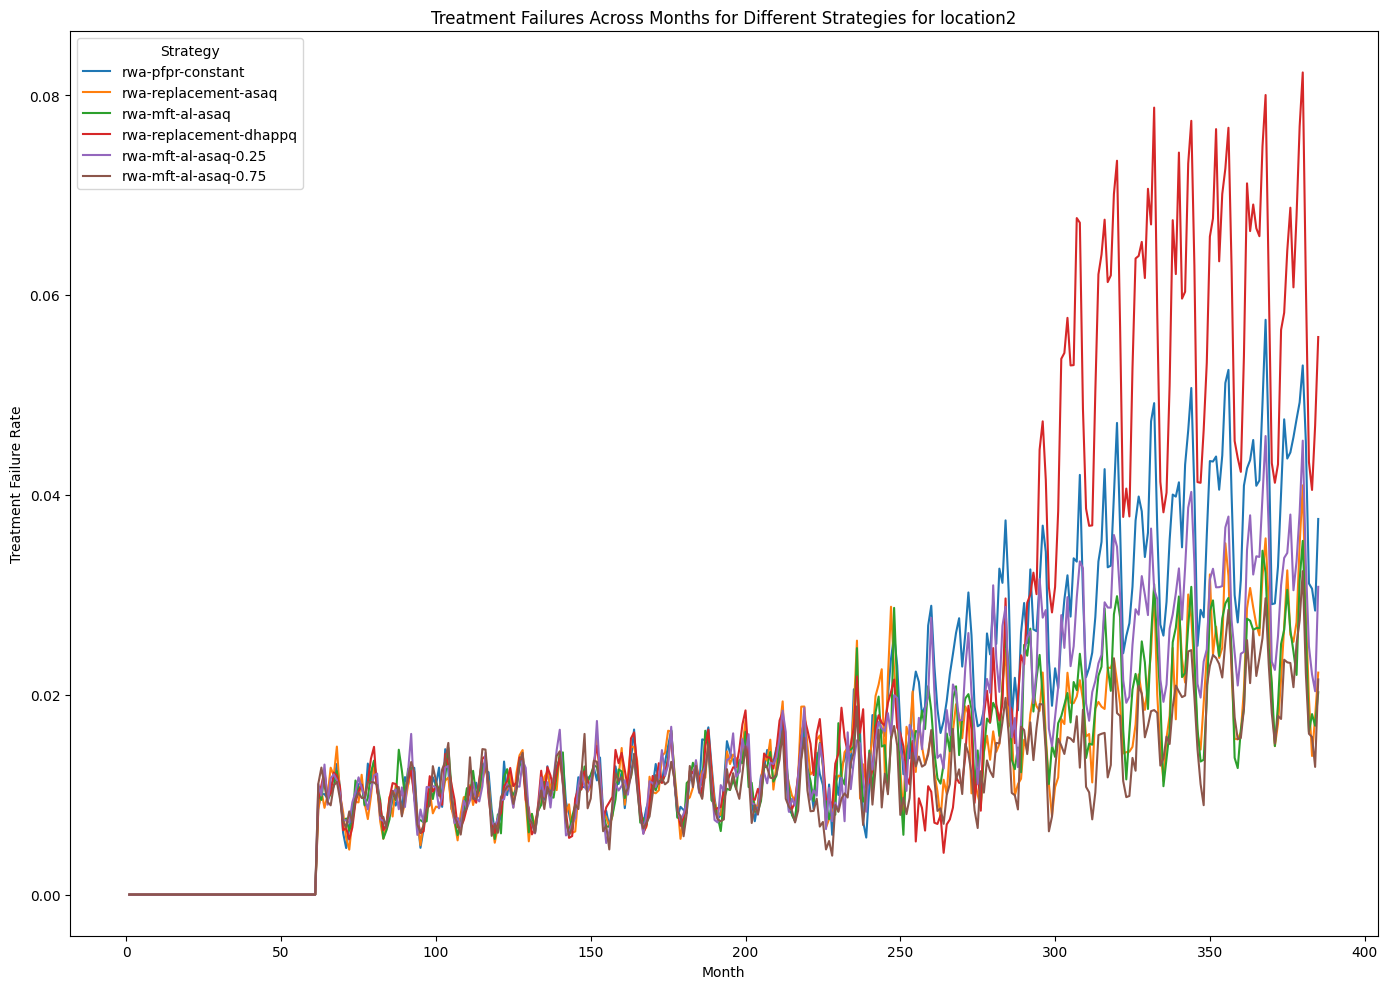

In [36]:
visualize_treatment_failures(strategy_tf_df, location_id)

In [37]:
def visualize_prevalence(df, location_id, column):
    
    plt.figure(figsize=(14, 10))

    # Loop through the unique strategies and plot a line for each
    for strategy in df['strategy'].unique():
        strategy_data = df[df['strategy'] == strategy]
        plt.plot(strategy_data['monthlydataid'], strategy_data[column], label=strategy)

    # Adding titles and labels
    plt.title('Pfpr Across Months for Different Strategies for location'+str(location_id))
    plt.xlabel('Month')
    plt.ylabel('pfpr')
    plt.legend(title='Strategy')

    plt.tight_layout()
    plt.show()
    # plt.savefig('prevalence_for_strategies_'+str(location_id) + '.png')  # Save the plot as a file
    plt.close()

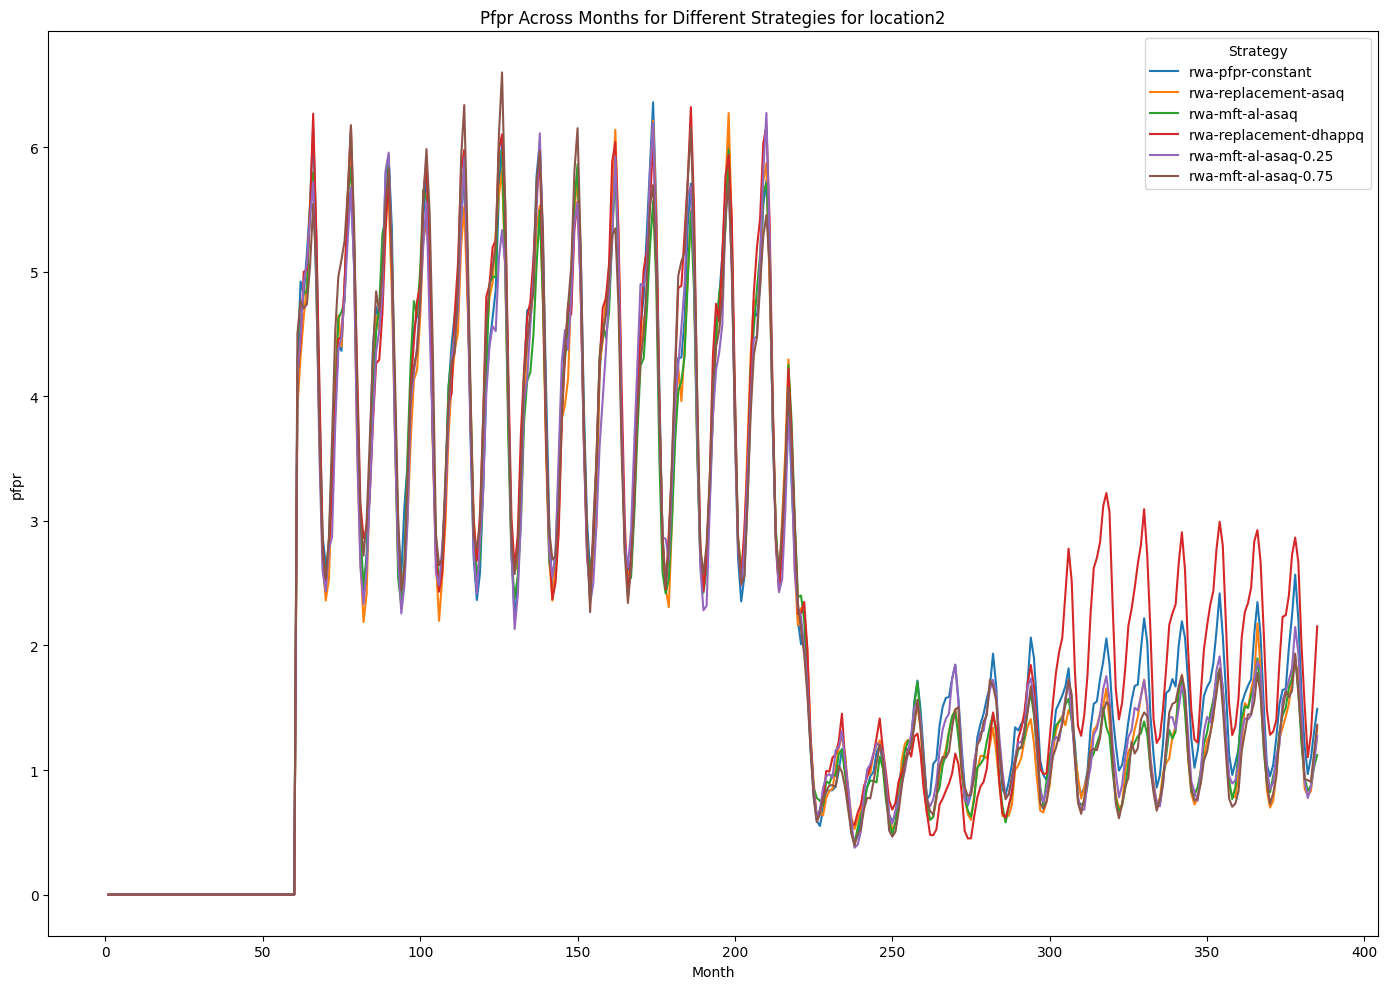

In [38]:
visualize_prevalence(strategy_tf_df, location_id, "pfprunder5" )

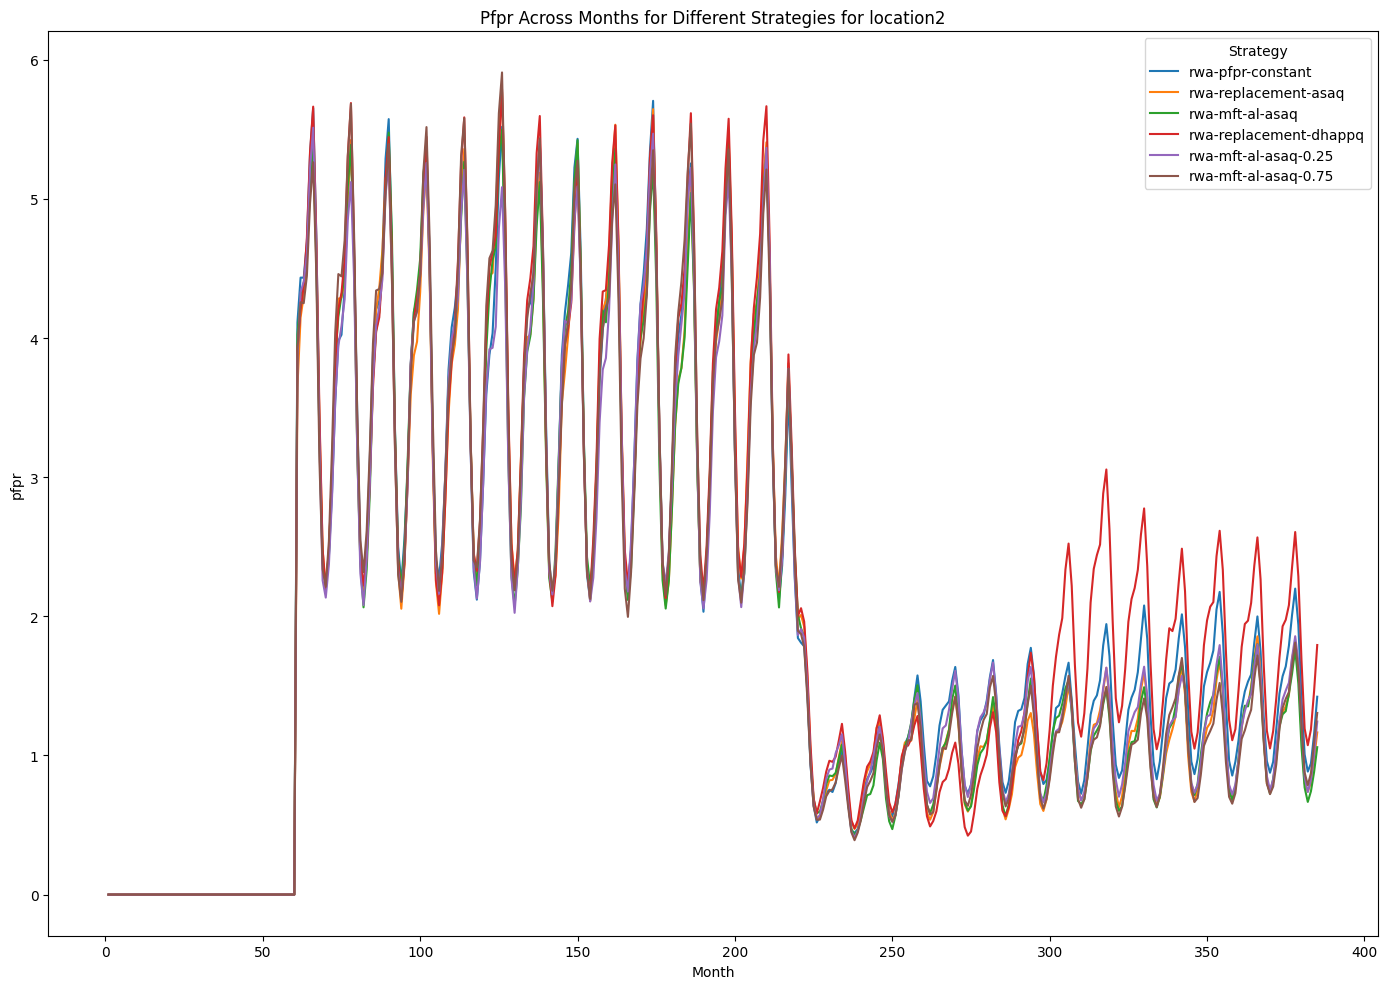

In [39]:
visualize_prevalence(strategy_tf_df, location_id, "pfprall" )